# Exploratory Data Analysis (Assignment # 4) - Team Forever Loop

**Authors:** Santosh Ganesan, Haran Nallasivan

**Date:** 23 September 2024

## Running this notebook

### Assumptions
We assume that you have a local installation of Python 3, as well as an IDE that can attach to a Python virtual environment and execute Jupyter notebooks, such as Visual Studio Code.

### Installation
#### Create a virtual environment
```
python -m venv .venv
```

#### Activate the virtual environment
Running on a UNIX-like machine (e.g. Mac, Linux, Codespaces):
```
source .venv/bin/activate
```

Running on Windows:
```
.venv/Scripts/activate
```

#### Install requirements
```
python -m pip install -r requirements.txt
```

#### Usage

Our notebook is `forever-loop-eda-ta4.ipynb`. You may run the code cells from this notebook. We recommend each time you run the notebook to restart the kernel and run all cells.

## Introduction

The *Welltory COVID-19 and Wearables Open Data Research* [1] dataset contains a wealth of data from wearables worn by participants who variably reported or didn't report COVID-19 symptoms. A problem that we were interested in exploring was predictability of COVID-19 symptoms based on this biometeric data, with a focus on blood pressure data.

The data was collected from Bluetooth-enabled heart rate monitors, high-resolution cameras through a method called Photoplethysmography (PPG), data collected from users' personal wearables, and clinically validated physical and mental health assessments [1]. 

## Data sourcing


In [1]:
# Import statements
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from pathlib import Path

Path('./data').mkdir(exist_ok=True)

# Helper function for extracting and persisting data
def extract_df(csv_name):
    '''
    Extracts dataframe from the data set given a CSV filename. Persists locally to avoid redudant network calls and unnecessary load on Github.

    Parameters:
        csv_name (str) - CSV filename, e.g. "blood_pressure"
    Returns:
        A pandas dataframe
    '''
    try:
        return pd.read_csv(f'./data/{csv_name}.csv')
    except:
        df = pd.read_csv(f'https://raw.githubusercontent.com/Welltory/hrv-covid19/refs/heads/master/data/{csv_name}.csv')
        df.to_csv(f'./data/{csv_name}.csv')
        return df

# Loaading the data frames
csv_names = ['blood_pressure', 'participants']
df = {}
for csv_name in csv_names:
    df[csv_name] = extract_df(csv_name)
df['blood_pressure'].head(2)

,Unnamed: 0,user_code,measurement_datetime,diastolic,systolic,functional_changes_index,circulatory_efficiency,kerdo_vegetation_index,robinson_index
0,0,01bad5a519,2020-04-29 22:33:33,100,150,NaN,NaN,NaN,NaN
1,1,01bad5a519,2020-04-30 01:33:33,100,150,NaN,NaN,NaN,NaN


## Questions we're asking

1. What are the dimensions of the dataset (number of rows and columns)?
1. What are the data types of the variables (numerical, categorical, text, etc.)?
1. Are there any missing values, and if so, how are they represented?

In [2]:
df['blood_pressure'].info()
print(f"Missing Values:\n{df['blood_pressure'].isnull().sum()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 721 entries, 0 to 720
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                721 non-null    int64  
 1   user_code                 721 non-null    object 
 2   measurement_datetime      721 non-null    object 
 3   diastolic                 721 non-null    int64  
 4   systolic                  721 non-null    int64  
 5   functional_changes_index  299 non-null    float64
 6   circulatory_efficiency    299 non-null    float64
 7   kerdo_vegetation_index    283 non-null    float64
 8   robinson_index            299 non-null    float64
dtypes: float64(4), int64(3), object(2)
memory usage: 50.8+ KB
Missing Values:
Unnamed: 0                    0
user_code                     0
measurement_datetime          0
diastolic                     0
systolic                      0
functional_changes_index    422
circulatory_efficien

In [3]:
df['participants'].info()
print(f"Missing Values:\n{df['participants'].isnull().sum()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185 entries, 0 to 184
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      185 non-null    int64  
 1   user_code       185 non-null    object 
 2   gender          185 non-null    object 
 3   age_range       185 non-null    object 
 4   city            173 non-null    object 
 5   country         179 non-null    object 
 6   height          183 non-null    float64
 7   weight          185 non-null    float64
 8   symptoms_onset  147 non-null    object 
dtypes: float64(2), int64(1), object(6)
memory usage: 13.1+ KB
Missing Values:
Unnamed: 0         0
user_code          0
gender             0
age_range          0
city              12
country            6
height             2
weight             0
symptoms_onset    38
dtype: int64


### Interpretation
The `blood_pressure` dataframe has 721 entries of which every entry has a `user_code`, a `measurement_datetime`, a `systolic` blood pressure value, and a `diastolic` blood pressure value. There are 400+ missing values of each of the remaining columns, which we'll exclude from our analysis as we're focusing on the systolic and diastolic blood pressure data.

The `participants` dataframe has 185 entries of which every entry has a `user_code`, `gender`, `age_range`, and `weight`. There is some missing geographical information (12 missing `city` values and 6 missing `country` values) and 2 missing `height` values. There are 38 missing values for `symptoms_onset`, which could mean that either the user didn't have symptoms or failed to report symptoms. 

### Transformation to add `reported_symptoms` column to participants

Here we want to add a new column dervied from `symptoms_onset` that more clearly describes whether or not the participant reported symptoms.

In [4]:
df['participants']['reported_symptoms'] = df['participants']['symptoms_onset'].apply(lambda x: 1 if pd.notnull(x) else 0)
df['participants'].head(3)

,Unnamed: 0,user_code,gender,age_range,city,country,height,weight,symptoms_onset,reported_symptoms
0,0,007b8190cf,m,25-34,Mandalay,Myanmar,170.18,96.162,NaN,0
1,1,013f6d3e5b,f,18-24,São Paulo,Brazil,174.00,77.300,5/15/2020,1
2,2,01bad5a519,m,45-54,St Petersburg,Russia,178.00,92.000,4/5/2020,1


### Transformation to add `timestamp` column to `blood_pressure`

Here we want to use the date-time strings to create a timestamp column of Pandas datetime objects.

In [5]:
df['blood_pressure']['timestamp'] = pd.to_datetime(df['blood_pressure']['measurement_datetime'])

### Adding a numeric gender column for correlation analysis

To more easily correlate our other numeric variables with gender, we're creating a `gender_index` column for which we've arbitrarily mapped `f` to 1 and `m` to 0.

In [6]:
df['participants']['gender_index'] = df['participants']['gender'].apply(lambda gender: 1 if gender == 'f' else 0)

### Joining the two datafames

We're joining the participant metadata dataframe into the blood pressure dataframe so that we can perform our analysis on a single denormalized table.

In [7]:
df['joined'] = pd.merge(df['blood_pressure'], df['participants'], on='user_code', how='left')
df['joined'].iloc[::10].head(10)

,Unnamed: 0_x,user_code,measurement_datetime,diastolic,systolic,functional_changes_index,circulatory_efficiency,kerdo_vegetation_index,robinson_index,timestamp,Unnamed: 0_y,gender,age_range,city,country,height,weight,symptoms_onset,reported_symptoms,gender_index
0,0,01bad5a519,2020-04-29 22:33:33,100,150,NaN,NaN,NaN,NaN,2020-04-29 22:33:33,2,m,45-54,St Petersburg,Russia,178.00,92.000,4/5/2020,1,0
10,10,01bad5a519,2020-05-03 21:25:34,80,120,2.92,3800.0,16.0,114.00,2020-05-03 21:25:34,2,m,45-54,St Petersburg,Russia,178.00,92.000,4/5/2020,1,0
20,20,01bad5a519,2020-05-11 20:15:55,80,118,NaN,NaN,NaN,NaN,2020-05-11 20:15:55,2,m,45-54,St Petersburg,Russia,178.00,92.000,4/5/2020,1,0
30,30,1b9321b648,2020-04-19 21:28:27,85,115,NaN,NaN,NaN,NaN,2020-04-19 21:28:27,21,f,25-34,Kamyshlov,Russia,154.00,67.000,4/11/2020,1,1
40,40,1ce1d77659,2020-05-12 14:21:59,75,121,2.45,3450.0,NaN,90.75,2020-05-12 14:21:59,22,m,25-34,Richmond Hill,United States,167.64,72.575,4/4/2020,1,0
50,50,1ed25f66e9,2020-05-21 11:18:22,80,120,NaN,NaN,NaN,NaN,2020-05-21 11:18:22,23,m,25-34,Draveil,France,176.00,82.500,3/14/2020,1,0
60,60,295ed96279,2020-01-06 09:24:51,70,110,2.10,2440.0,NaN,67.10,2020-01-06 09:24:51,34,m,35-44,Moscow,Russia,166.00,55.000,5/11/2020,1,0
70,70,295ed96279,2020-01-18 10:36:20,65,105,NaN,NaN,NaN,NaN,2020-01-18 10:36:20,34,m,35-44,Moscow,Russia,166.00,55.000,5/11/2020,1,0
80,80,425969dc69,2020-05-04 21:42:10,76,114,NaN,NaN,NaN,NaN,2020-05-04 21:42:10,51,f,35-44,London,United Kingdom,170.18,76.203,3/11/2020,1,1
90,90,6be5033971,2020-04-15 19:53:36,80,131,NaN,NaN,NaN,NaN,2020-04-15 19:53:36,81,f,45-54,Kyiv,Ukraine,164.00,58.500,3/28/2020,1,1


## Questions we're asking

1. What does this blood pressure data look like visually for users that reported symptoms versus users that didn't?

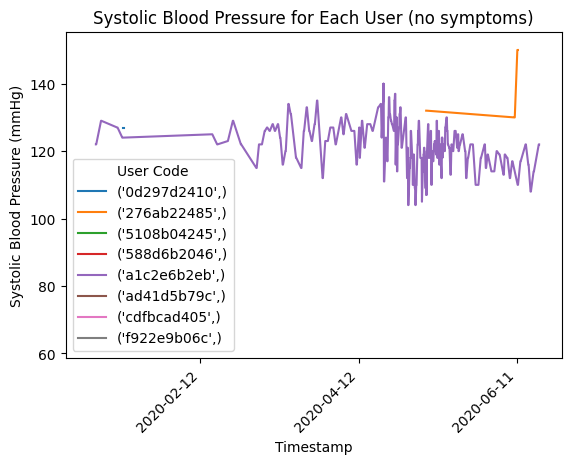

In [8]:
# Create a figure and axis
fig, ax = plt.subplots()

# Systolic blood pressure for participants who didn't report symptoms
for key, grp in df['joined'][df['joined']['reported_symptoms'] == 0].groupby(['user_code']):
    ax.plot(grp['timestamp'], grp['systolic'], label=key)

# Format the x-axis to show dates at sensible intervals
ax.xaxis.set_major_locator(mdates.DayLocator(interval=60))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Add legend, title, and labels
ax.legend(title='User Code')
ax.set_title('Systolic Blood Pressure for Each User (no symptoms)')
ax.set_xlabel('Timestamp')
ax.set_ylabel('Systolic Blood Pressure (mmHg)')

# Rotate labels
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.subplots_adjust(bottom=0.2)

# Show the plot
plt.show()


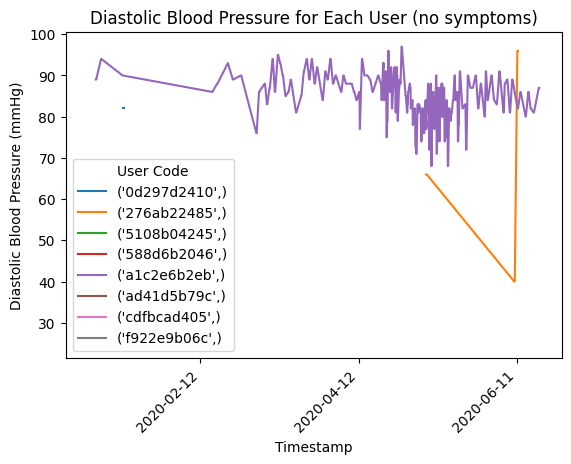

In [9]:
# Create a figure and axis
fig, ax = plt.subplots()

# Diastolic blood pressure for participants who didn't report symptoms
for key, grp in df['joined'][df['joined']['reported_symptoms'] == 0].groupby(['user_code']):
    ax.plot(grp['timestamp'], grp['diastolic'], label=key)

# Format the x-axis to show dates at sensible intervals
ax.xaxis.set_major_locator(mdates.DayLocator(interval=60))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Add legend, title, and labels
ax.legend(title='User Code')
ax.set_title('Diastolic Blood Pressure for Each User (no symptoms)')
ax.set_xlabel('Timestamp')
ax.set_ylabel('Diastolic Blood Pressure (mmHg)')

# Rotate labels
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.subplots_adjust(bottom=0.2)

# Show the plot
plt.show()

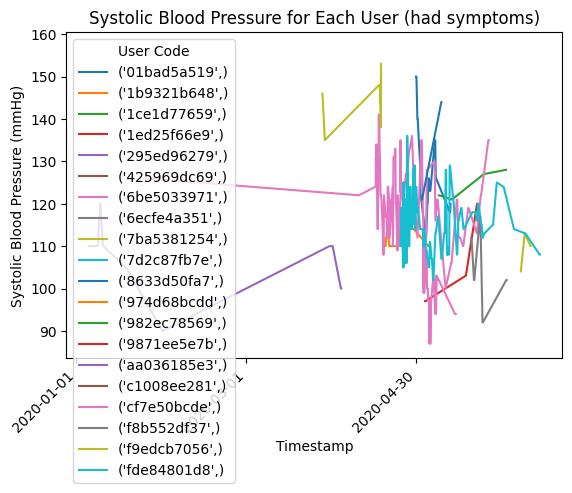

In [10]:
# Random sampling of user codes
sampled_user_codes = df['joined'][df['joined']['reported_symptoms'] == 1]['user_code'].drop_duplicates().sample(n=20, random_state=1)

# Create a figure and axis
fig, ax = plt.subplots()

# Systolic blood pressure for sampled participants who reported having symptoms
for key, grp in df['joined'][df['joined']['user_code'].isin(sampled_user_codes)].groupby(['user_code']):
    ax.plot(grp['timestamp'], grp['systolic'], label=key)

# Format the x-axis to show dates at sensible intervals
ax.xaxis.set_major_locator(mdates.DayLocator(interval=60))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Add legend, title, and labels
ax.legend(title='User Code')
ax.set_title('Systolic Blood Pressure for Each User (had symptoms)')
ax.set_xlabel('Timestamp')
ax.set_ylabel('Systolic Blood Pressure (mmHg)')

# Rotate labels
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.subplots_adjust(bottom=0.2)

# Show the plot
plt.show()


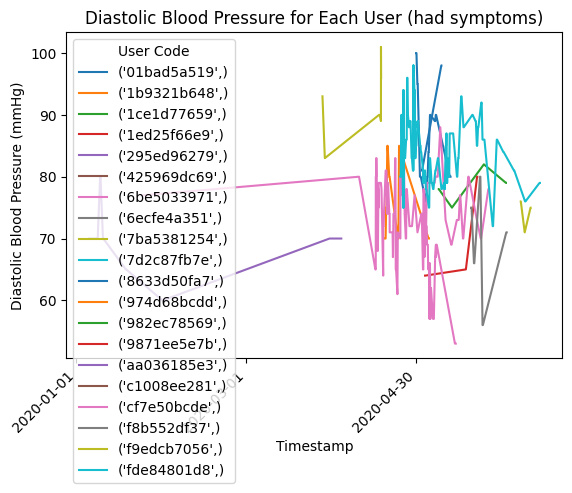

In [11]:
# Create a figure and axis
fig, ax = plt.subplots()

# Diastolic blood pressure for sampled participants who reported having symptoms
for key, grp in df['joined'][df['joined']['user_code'].isin(sampled_user_codes)].groupby(['user_code']):
    ax.plot(grp['timestamp'], grp['diastolic'], label=key)

# Format the x-axis to show dates at sensible intervals
ax.xaxis.set_major_locator(mdates.DayLocator(interval=60))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Add legend, title, and labels
ax.legend(title='User Code')
ax.set_title('Diastolic Blood Pressure for Each User (had symptoms)')
ax.set_xlabel('Timestamp')
ax.set_ylabel('Diastolic Blood Pressure (mmHg)')

# Rotate labels
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.subplots_adjust(bottom=0.2)

# Show the plot
plt.show()

### Interpretation

Of the participants who did not report symptoms, only one participant consistently produced blood pressure data through usage of their wearable. The other participants show sporadic usage of their wearable.

There's a similar inconsistency for the users who did report symptoms, which indicates that for our analysis, we should hone in on the users that consistently used their wearable.

## Questions we're asking

1. What are some descriptive statistics for each of our variables?
1. What are the distributions for each of our variables? Are any of them not normal/skewed?
1. Are there any noticeable outliers?

In [12]:
# Descriptive Statistics
print("\nDescriptive Statistics")
print("----------------------")
numeric_columns = df['joined'].select_dtypes(include=[np.number]).columns
print("Central Tendency Measures:")
print(df['joined'][numeric_columns].describe().loc[['mean', '50%']])
print("\nDispersion Measures:")
print(df['joined'][numeric_columns].describe().loc[['std', 'min', 'max']])




Descriptive Statistics
----------------------
Central Tendency Measures:
      Unnamed: 0_x  diastolic    systolic  functional_changes_index  \
mean         360.0  81.228849  119.441054                  2.594013   
50%          360.0  82.000000  120.000000                  2.580000   

      circulatory_efficiency  kerdo_vegetation_index  robinson_index  \
mean             2735.197057              -15.498233       84.663779   
50%              2640.000000              -17.000000       83.220000   

      Unnamed: 0_y      height    weight  reported_symptoms  gender_index  
mean    114.603329  170.140166  72.84262           0.517337      0.432732  
50%     120.000000  174.000000  73.40000           1.000000      0.000000  

Dispersion Measures:
     Unnamed: 0_x   diastolic    systolic  functional_changes_index  \
std     208.27906    8.865761   10.522578                  0.291302   
min       0.00000   25.000000   63.000000                  1.680000   
max     720.00000  101.000000  1

In [13]:
# Check for distribution normality (skewness and kurtosis)
print("\nDistribution Measures:")
print("------------------------")
print(df['joined'][numeric_columns].skew())
print(df['joined'][numeric_columns].kurt())


Distribution Measures:
------------------------
Unnamed: 0_x                0.000000
diastolic                  -1.060136
systolic                   -0.101898
functional_changes_index    0.396673
circulatory_efficiency      1.842725
kerdo_vegetation_index      0.309302
robinson_index              0.984648
Unnamed: 0_y               -0.484758
height                     -0.542011
weight                      1.353753
reported_symptoms          -0.069535
gender_index                0.272106
dtype: float64
Unnamed: 0_x               -1.200000
diastolic                   3.050401
systolic                    1.917806
functional_changes_index    1.429425
circulatory_efficiency      8.483504
kerdo_vegetation_index      0.945551
robinson_index              3.560853
Unnamed: 0_y                0.112176
height                      1.132534
weight                      5.486976
reported_symptoms          -2.000723
gender_index               -1.931324
dtype: float64



Data Quality
------------
Duplicated Rows: 0
Checking for Inconsistent Values:
                           most_frequent_value
Unnamed: 0_x                                 0
user_code                           a1c2e6b2eb
measurement_datetime      2020-05-11  00:27:56
diastolic                                   80
systolic                                   122
functional_changes_index                  2.56
circulatory_efficiency                  2160.0
kerdo_vegetation_index                   -32.0
robinson_index                            73.2
timestamp                  2020-05-11 00:27:56
Unnamed: 0_y                               120
gender                                       m
age_range                                35-44
city                                    Moscow
country                                 Russia
height                                   174.0
weight                                    73.4
symptoms_onset                       4/16/2020
reported_symptoms          

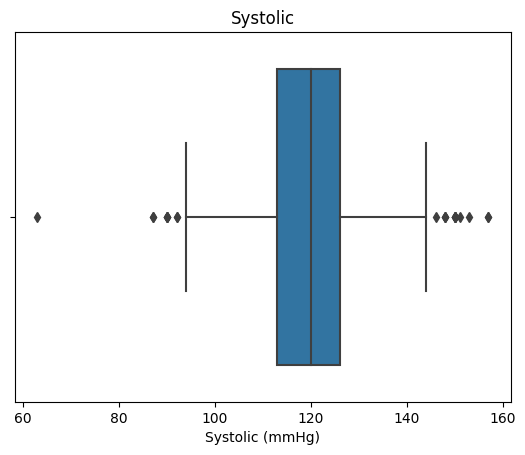

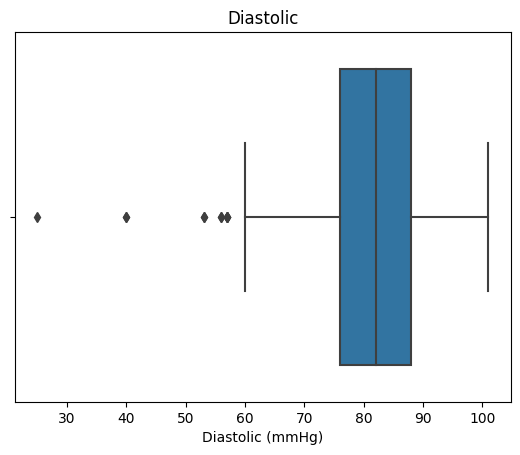

In [14]:

# Data Quality
print("\nData Quality")
print("------------")
print(f"Duplicated Rows: {df['joined'].duplicated().sum()}")
print("Checking for Inconsistent Values:")
print(df['joined'].apply(lambda x: x.value_counts().index[0]).to_frame('most_frequent_value'))


sns.boxplot(df['blood_pressure'], x='systolic')
plt.title('Systolic')
plt.xlabel('Systolic (mmHg)')
plt.show()
sns.boxplot(df['blood_pressure'], x='diastolic')
plt.title('Diastolic')
plt.xlabel('Diastolic (mmHg)')
plt.show()


### Interpretation

The boxplots above show the systolic and diastolic bloos pressures for both participants with and without reported symptoms. Systolic numbers show more variation, both above and below the mean, while diastolic shows outliers only below the mean.

The outliers will be highlighted in further analysis below (Cleanup(outliers)) to determine any relevant correlations or characterizations.  

## Questions we're asking

1) How do we identify missing values?
1) How are our variables correlated?
1) How should we sample the data?
1) Does this effect change after we remove outliers, duplicates, and null values?

### Identifying Missing values

To identify missing values, we will first inspect how many datapoints were logged by each user.



In [15]:
value_counts = df['joined']['user_code'].value_counts()
print("\nCount of datapoints for each user_code:\n", value_counts)



Count of datapoints for each user_code:
 user_code
a1c2e6b2eb    333
fde84801d8    128
6be5033971    105
cf7e50bcde     24
01bad5a519     23
295ed96279     22
1b9321b648     13
6ecfe4a351     10
7ba5381254      9
1ce1d77659      8
276ab22485      6
f9edcb7056      6
1ed25f66e9      6
8633d50fa7      4
0d297d2410      2
974d68bcdd      2
7d2c87fb7e      2
9871ee5e7b      2
588d6b2046      2
c1008ee281      2
f8b552df37      2
f922e9b06c      2
425969dc69      2
982ec78569      2
aa036185e3      1
ad41d5b79c      1
cdfbcad405      1
5108b04245      1
Name: count, dtype: int64


Of these users, only 3 logged more than 100 datapoints, with the rest of the users showing a sharp dropoff in the usage of their wearables. The user that logged the most datapoints was the one participant who did not report symptoms but showed consistent usage of their wearable from the previous set of plots. The other two users who logged more than 100 datapoints did report symptoms and can be seen in the previous plots despite the random sampling.

For our analysis, having a few more participants who didn't report symptoms would help to analyze the correlation between blood pressure and symptomatic COVID-19. Let us filter the above counts to just the users who didn't report symptoms.

In [16]:
value_counts = df['joined'][df['joined']['reported_symptoms'] == 0]['user_code'].value_counts()
print("\nCount of datapoints for each user_code:\n", value_counts)


Count of datapoints for each user_code:
 user_code
a1c2e6b2eb    333
276ab22485      6
0d297d2410      2
588d6b2046      2
f922e9b06c      2
5108b04245      1
ad41d5b79c      1
cdfbcad405      1
Name: count, dtype: int64


The above results aren't promising. The participant who didn't report symptoms that logged the second highest number of datapoints only logged 6. Also, of the 38 participants in the whole dataset who didn't report symptoms, only 8 produced blood pressure data from their wearables.

In [17]:
threshold = 100
filtered_df = df['joined'][df['joined']['user_code'].map(df['joined']['user_code'].value_counts()) >= threshold]
unique_values_f = filtered_df['user_code'].unique()
value_counts_f = filtered_df['user_code'].value_counts()
print("\nCount of each unique value in 'unique_values_f' column:\n", value_counts_f)


Count of each unique value in 'unique_values_f' column:
 user_code
a1c2e6b2eb    333
fde84801d8    128
6be5033971    105
Name: count, dtype: int64


There are only 3 participants who recorded more than 100 datapoints, of which 2 reported symptoms and 1 did not.

Before we proceed with sampling and cleanup, it would be interesting to see the correlation between our variables from this raw data.

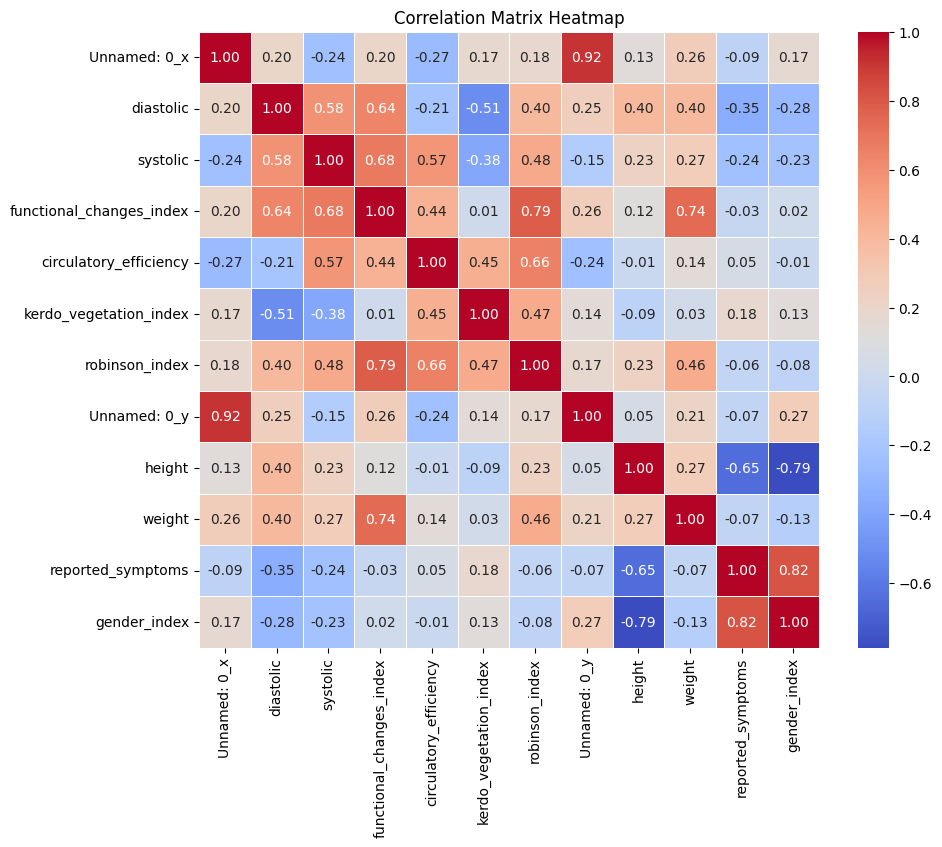

In [18]:
numeric_columns = df['joined'].select_dtypes(include=[np.number]).columns
correlation_matrix = df['joined'][numeric_columns].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

We can ignore the two "Unnamed" that resulted from joining the `blood_pressure` and `participants` data frames. Note that this correlation matrix was produced based on the raw timeseries data across multiple participants. 

We can see that the most correlated variables are the `functional_changes_index` with the `robinson_index`, `weight`, and the `systolic` and `diastolic` blood pressures. Height and weight are somewhat correlated with each other. Height and weight are also more correlated with diastolic blood pressure than systolic, though there's some correlation with both. 

Gender is most correlated with whether the participant reported symptoms (potential source of bias in reporting symptoms) and height, and somewhat correlated with systolic and diastolic blood pressure. 

The systolic and diastolic blood pressures are themselves correlated, and they're both correlated with the `robinson_index`. Both blood pressure readings are inversely correlated with whether the participant reported symptoms, meaning that the participants that reported symptoms tended to have lower blood pressure readings. Note that this correlation is still noticeable even though we're averaging over participants and it's evident that blood pressure is also correlated with height, weight, and gender.

### Sampling

Our initial approach for sampling will be to be stratify across our categorical variables (`gender` and `reported_symptoms`) and then perform systematic sampling across the time series.

In [19]:
# Below code generated by ChatGPT
def systematic_sampling(df, step):
    """
    Perform systematic sampling on a dataframe by selecting every nth row.

    Parameters:
    df (pd.DataFrame): The dataframe from which to sample.
    step (int): The step size for systematic sampling, i.e., every nth row is selected.

    Returns:
    pd.DataFrame: A dataframe containing the systematically sampled rows.
    """
    return df.iloc[::step]

def stratified_systematic_sampling(df, stratify_columns, step=2):
    """
    Perform stratified systematic sampling on a dataframe, balancing the classes across categorical columns.

    The function groups the dataframe by the specified stratification columns, 
    performs systematic sampling within each group, and ensures that the classes 
    are balanced by sampling the same number of rows from each group based on the 
    smallest group size.

    Parameters:
    df (pd.DataFrame): The dataframe containing the data to be sampled.
    stratify_columns (list): List of column names to use for stratification (e.g., ['gender', 'reported_symptoms']).
    step (int): The step size for systematic sampling within each group. Defaults to 2.

    Returns:
    pd.DataFrame: A dataframe containing the balanced, systematically sampled rows across all groups.
    """
    # Group by the stratification columns
    grouped = df.groupby(stratify_columns)
    
    # Find the size of the smallest group to balance all classes
    min_group_size = grouped.size().min()
    
    # List to hold sampled dataframes
    sampled_dfs = []
    
    for _, group in grouped:
        # Perform systematic sampling
        if len(group) >= step:
            sampled_group = systematic_sampling(group, step)
        else:
            sampled_group = group
        
        # Ensure balancing by sampling only up to the size of the smallest group
        # If the group size is smaller than the min_group_size, take the whole group
        if len(sampled_group) >= min_group_size:
            sampled_dfs.append(sampled_group.sample(n=min_group_size, random_state=42))
        else:
            sampled_dfs.append(sampled_group)
    
    # Combine all the sampled dataframes
    balanced_sampled_df = pd.concat(sampled_dfs)
    
    return balanced_sampled_df

# END OF CODE GENERATED BY CHATGPT

stratify_columns = ['gender', 'reported_symptoms']
balanced_sampled_df = stratified_systematic_sampling(df['joined'], stratify_columns, step=1)
print(len(balanced_sampled_df[(balanced_sampled_df['gender'] == 'f') & (balanced_sampled_df['reported_symptoms'] == 0)]))
print(len(balanced_sampled_df[(balanced_sampled_df['gender'] == 'm') & (balanced_sampled_df['reported_symptoms'] == 0)]))
print(len(balanced_sampled_df[(balanced_sampled_df['gender'] == 'f') & (balanced_sampled_df['reported_symptoms'] == 1)]))
print(len(balanced_sampled_df[(balanced_sampled_df['gender'] == 'm') & (balanced_sampled_df['reported_symptoms'] == 1)]))

5
5
5
5


Because we're taking the size of the smallest group as the maximum number of samples per group, we're losing a lot of information due to the correlation between gender and reporting symptoms. Therefore, we need to change our approach and only sample based on `reported_symptoms`.

In [20]:
stratify_columns = ['reported_symptoms']
balanced_sampled_df = stratified_systematic_sampling(df['joined'], stratify_columns, step=1)
print(len(balanced_sampled_df[(balanced_sampled_df['gender'] == 'f') & (balanced_sampled_df['reported_symptoms'] == 0)]))
print(len(balanced_sampled_df[(balanced_sampled_df['gender'] == 'm') & (balanced_sampled_df['reported_symptoms'] == 0)]))
print(len(balanced_sampled_df[(balanced_sampled_df['gender'] == 'f') & (balanced_sampled_df['reported_symptoms'] == 1)]))
print(len(balanced_sampled_df[(balanced_sampled_df['gender'] == 'm') & (balanced_sampled_df['reported_symptoms'] == 1)]))

5
343
284
64


This is now both balanced across our two classses as well as has a sufficient amount of data for our analysis. Let's see our correlation heatmap again.

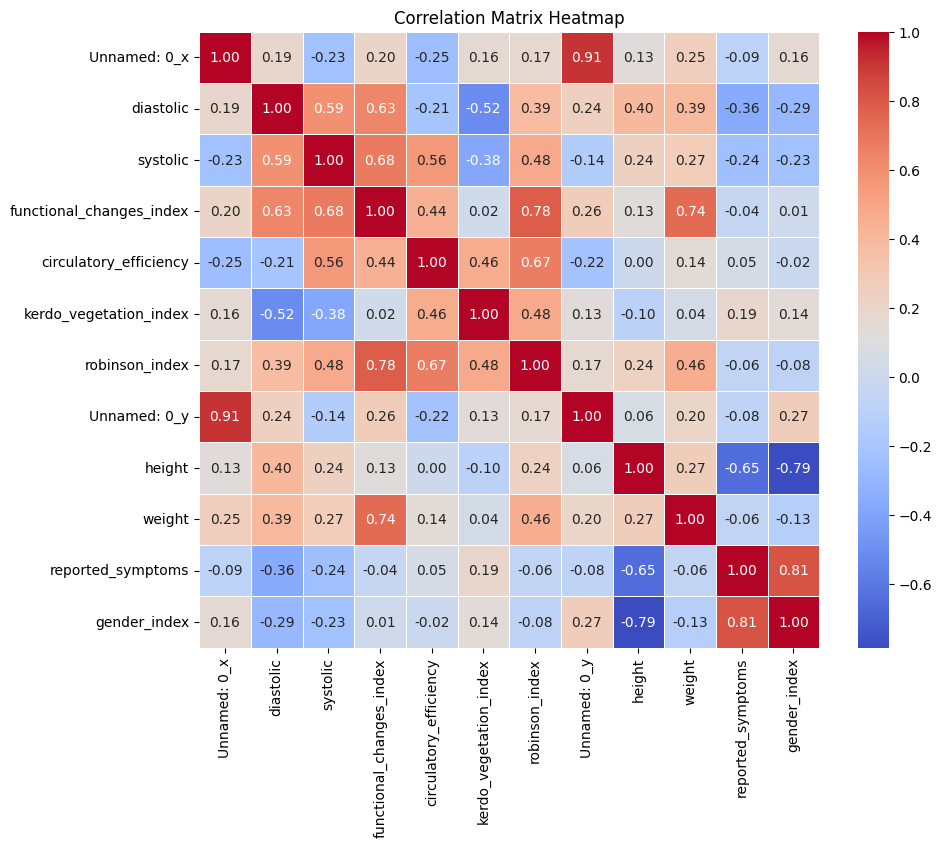

In [21]:
numeric_columns = balanced_sampled_df.select_dtypes(include=[np.number]).columns
correlation_matrix = balanced_sampled_df[numeric_columns].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

## Cleanup

### Just the right variables
We're going to focus our analysis on a few variables of interest: `gender`/`gender_index`, `diastolic`, `reported_symptoms`, `height`, and `weight`. We're dropping the unnamed index columns from the merge operation, and we're dropping `functional_changes_index`, `circulatory_efficiency`, `kerdo_vegetation_index`, and `robinson_index` because these have low correlation with `reported_symptoms`. We're dropping `systolic` blood pressure because of its strong correlation with `diastolic` blood pressure, but we're keeping `height` and `weight` for feature engineering.


In [22]:
cleaned_df = balanced_sampled_df[['gender', 'gender_index', 'diastolic', 'reported_symptoms', 'height', 'weight']]
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 696 entries, 465 to 21
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             696 non-null    object 
 1   gender_index       696 non-null    int64  
 2   diastolic          696 non-null    int64  
 3   reported_symptoms  696 non-null    int64  
 4   height             696 non-null    float64
 5   weight             696 non-null    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 38.1+ KB


In [23]:
cleaned_df.describe()

,gender_index,diastolic,reported_symptoms,height,weight
count,696.000000,696.000000,696.00000,696.000000,696.000000
mean,0.415230,81.251437,0.50000,170.270833,72.900438
std,0.493116,8.911798,0.50036,5.305592,11.466268
min,0.000000,25.000000,0.00000,154.000000,47.673000
25%,0.000000,76.000000,0.00000,166.000000,72.575000
50%,0.000000,82.000000,0.50000,174.000000,73.400000
75%,1.000000,88.000000,1.00000,174.000000,79.500000
max,1.000000,101.000000,1.00000,193.000000,130.300000


### Missing Data
As seen above in the `.info()` output, there is no missing data.

### Duplicates

In [24]:
cleaned_df.drop_duplicates()
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 696 entries, 465 to 21
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             696 non-null    object 
 1   gender_index       696 non-null    int64  
 2   diastolic          696 non-null    int64  
 3   reported_symptoms  696 non-null    int64  
 4   height             696 non-null    float64
 5   weight             696 non-null    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 38.1+ KB


There are no duplicates.

### Outliers

`diastolic`, `height`, and `weight` now our only continuous variables.

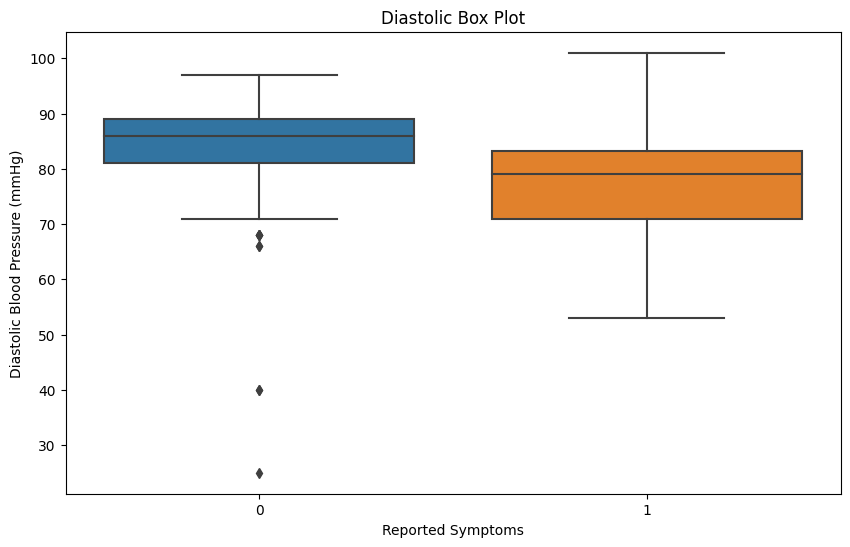

In [25]:
# Box plots to identify outliers
plt.figure(figsize=(10, 6))
sns.boxplot(data=cleaned_df, x='reported_symptoms', y='diastolic')
plt.title('Diastolic Box Plot')
plt.xlabel('Reported Symptoms')
plt.ylabel('Diastolic Blood Pressure (mmHg)')
plt.show()

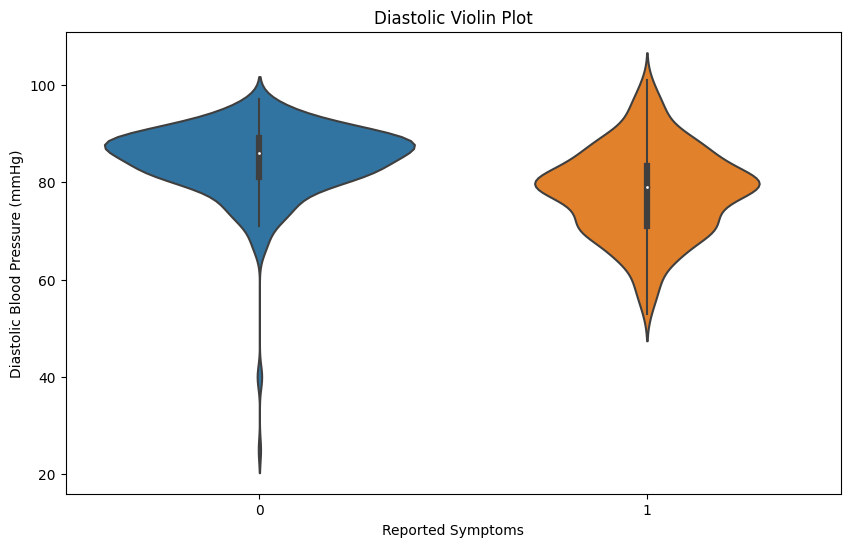

In [26]:
# Violin plot to identify correlation of outliers with reported_symptoms
plt.figure(figsize=(10, 6))
sns.violinplot(x="reported_symptoms", y="diastolic", data=cleaned_df)
plt.title('Diastolic Violin Plot')
plt.xlabel('Reported Symptoms')
plt.ylabel('Diastolic Blood Pressure (mmHg)')
plt.show()

The outliers don't appear to be true, and this is corroborated by the fact that there were few participants who did not report symptoms. Therefore, we will remove them.

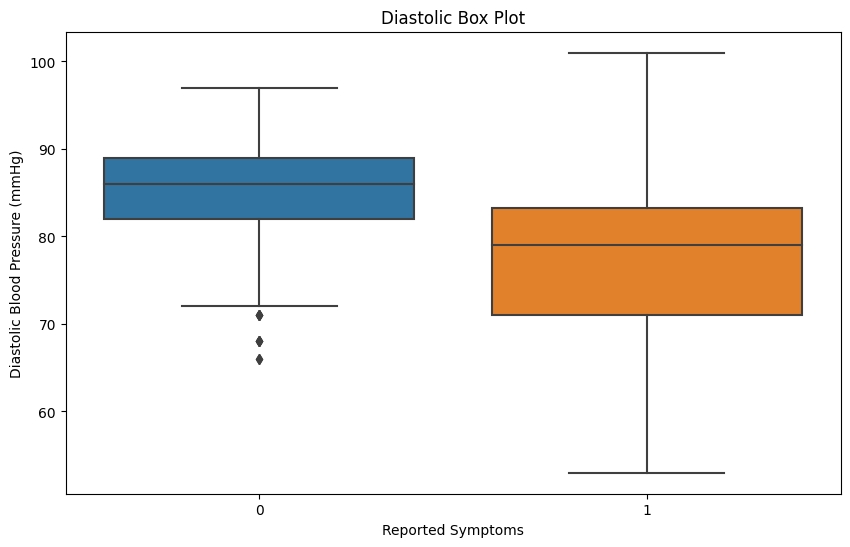

In [27]:
cleaned_df = cleaned_df[(cleaned_df['reported_symptoms'] == 1) | ((cleaned_df['reported_symptoms'] == 0) & (cleaned_df['diastolic'] >= 50))]
plt.figure(figsize=(10, 6))
sns.boxplot(data=cleaned_df, x='reported_symptoms', y='diastolic')
plt.title('Diastolic Box Plot')
plt.xlabel('Reported Symptoms')
plt.ylabel('Diastolic Blood Pressure (mmHg)')
plt.show()

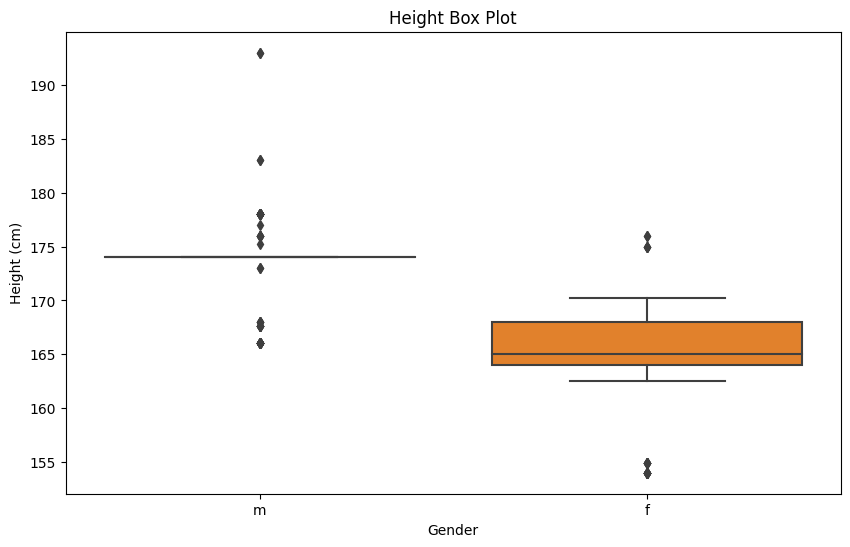

In [28]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=cleaned_df, x='gender', y='height')
plt.title('Height Box Plot')
plt.xlabel('Gender')
plt.ylabel('Height (cm)')
plt.show()

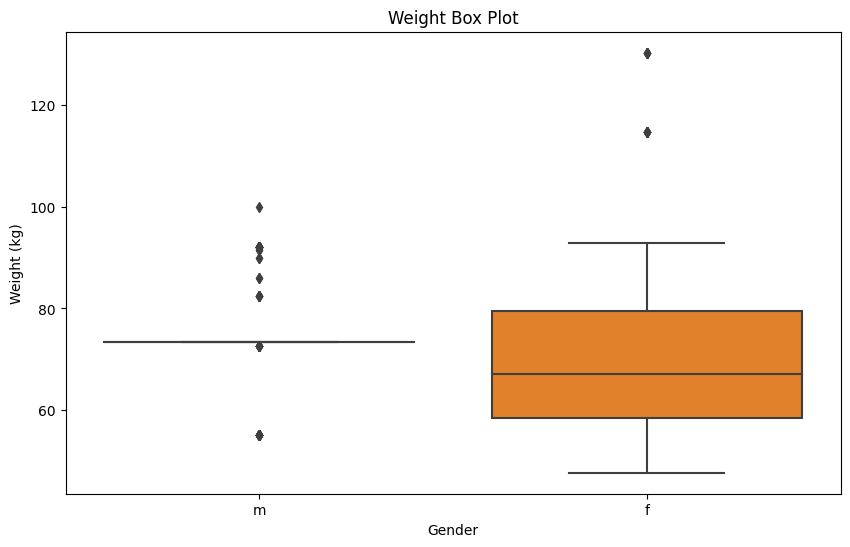

In [29]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=cleaned_df, x='gender', y='weight')
plt.title('Weight Box Plot')
plt.xlabel('Gender')
plt.ylabel('Weight (kg)')
plt.show()

The height and weight outliers intuitively look to be true, so we won't remove them.

## Feature Engineering

Though we suspect `height` is only correlated with `reported_symptoms` by the gender bias and `weight` by itself has low correlation, it would be interesting to see the correlation with body mass index (BMI), which is formulated as weight in kilograms over height in meters squarerd.

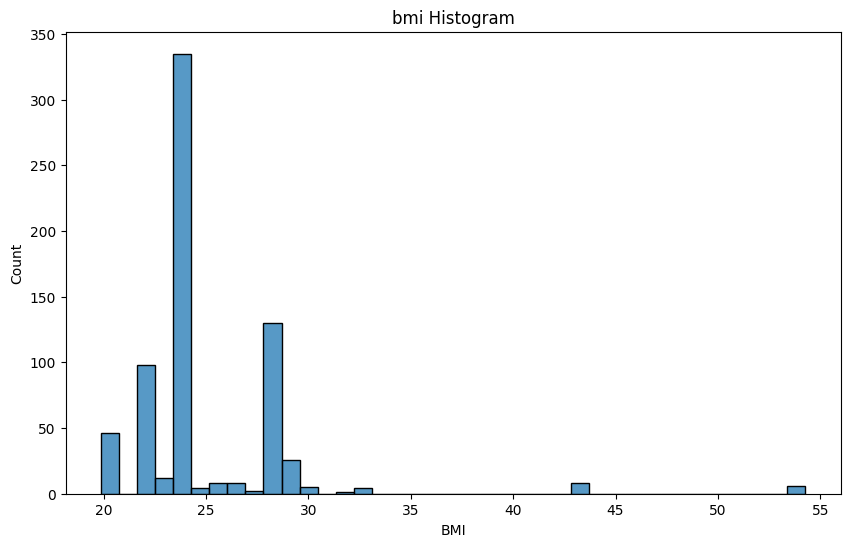

In [30]:
cleaned_df['bmi'] = cleaned_df['weight'] / np.power(cleaned_df['height'] / 100, 2)

plt.figure(figsize=(10, 6))
sns.histplot(data=cleaned_df, x='bmi')
plt.title('bmi Histogram')
plt.xlabel('BMI')
plt.ylabel('Count')
plt.show()

The distribution is skewed, so we will apply a logarithm to the column.

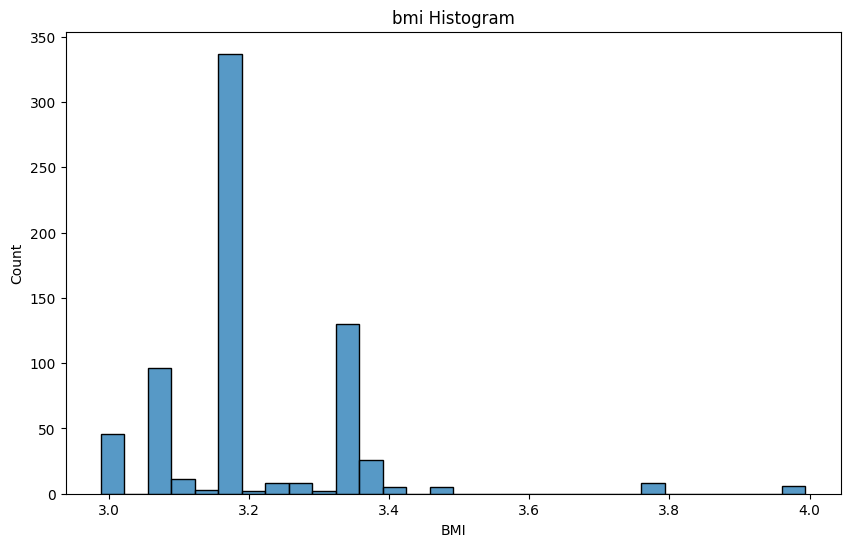

In [31]:
cleaned_df['bmi'] = np.log(cleaned_df['bmi'])

plt.figure(figsize=(10, 6))
sns.histplot(data=cleaned_df, x='bmi')
plt.title('bmi Histogram')
plt.xlabel('BMI')
plt.ylabel('Count')
plt.show()

## Data Transformation

We will now normalize `diastolic`.

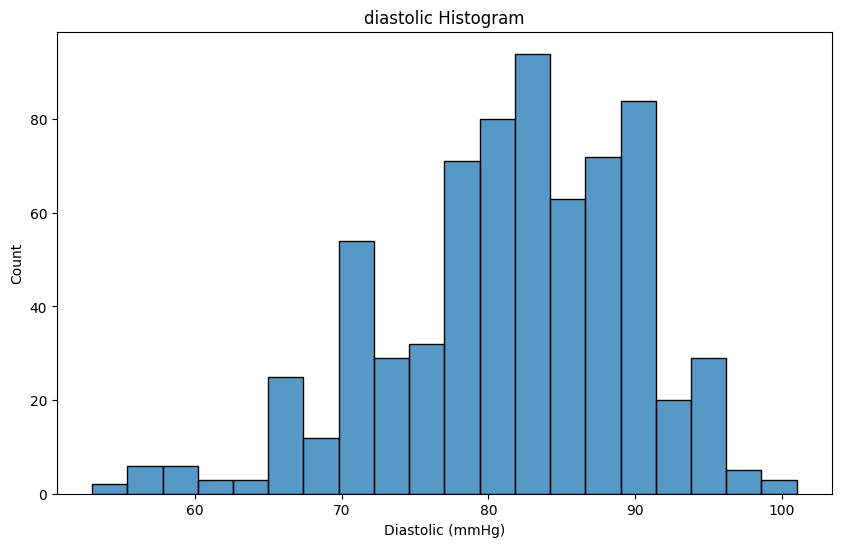

In [32]:
plt.figure(figsize=(10, 6))
sns.histplot(data=cleaned_df, x='diastolic')
plt.title('diastolic Histogram')
plt.xlabel('Diastolic (mmHg)')
plt.ylabel('Count')
plt.show()

The distribution looks roughly normal, so we'll use z-score scaling.

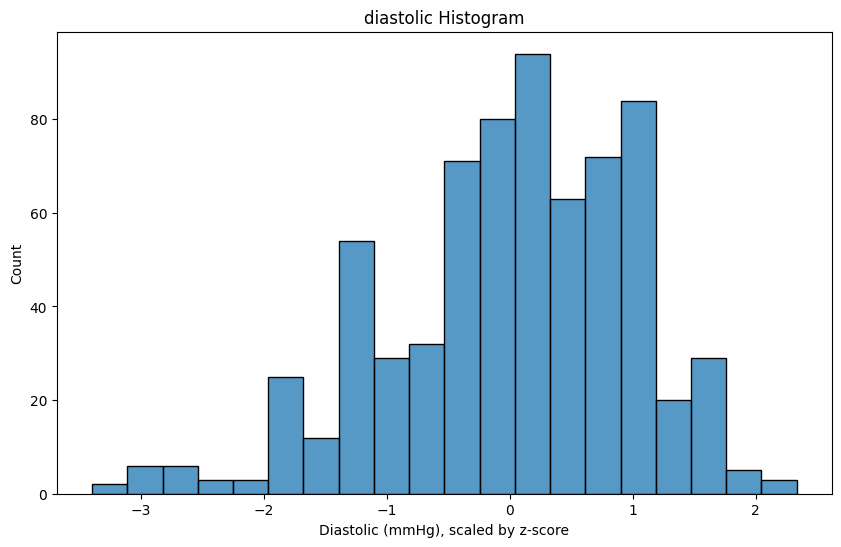

In [33]:
normalized_df = cleaned_df.copy()
normalized_df['diastolic'] = (normalized_df['diastolic'] - normalized_df['diastolic'].mean()) / normalized_df['diastolic'].std()

plt.figure(figsize=(10, 6))
sns.histplot(data=normalized_df, x='diastolic')
plt.title('diastolic Histogram')
plt.xlabel('Diastolic (mmHg), scaled by z-score')
plt.ylabel('Count')
plt.show()

We will now normalize `bmi`.

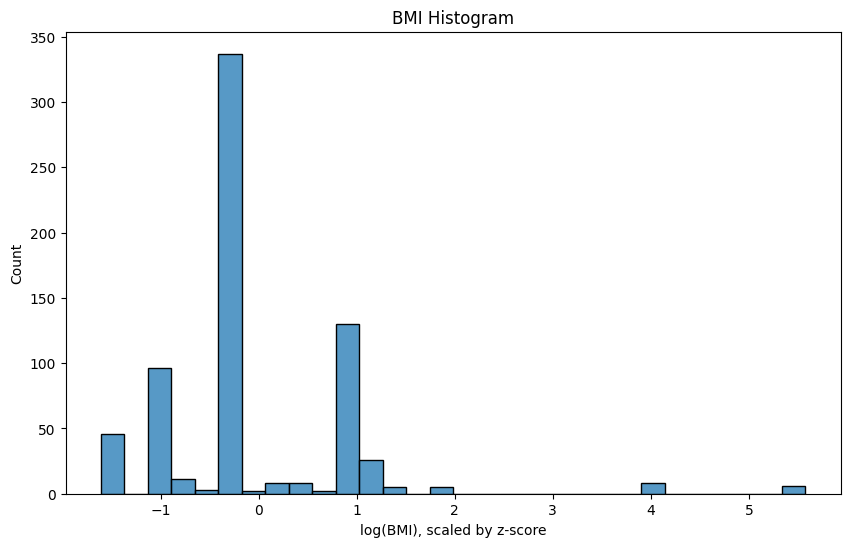

In [34]:
normalized_df['bmi'] = (normalized_df['bmi'] - normalized_df['bmi'].mean()) / normalized_df['bmi'].std()

plt.figure(figsize=(10, 6))
sns.histplot(data=normalized_df, x='bmi')
plt.title('BMI Histogram')
plt.xlabel('log(BMI), scaled by z-score')
plt.ylabel('Count')
plt.show()

## Variable Relationships

Let's view our correlation heatmap again along with some pair plots.

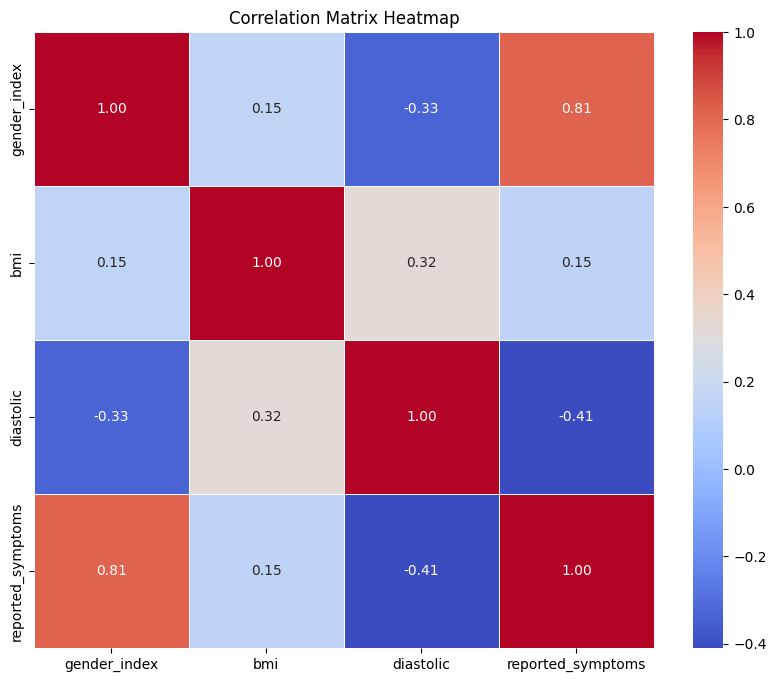

In [35]:
correlation_matrix = normalized_df[['gender_index', 'bmi', 'diastolic', 'reported_symptoms']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

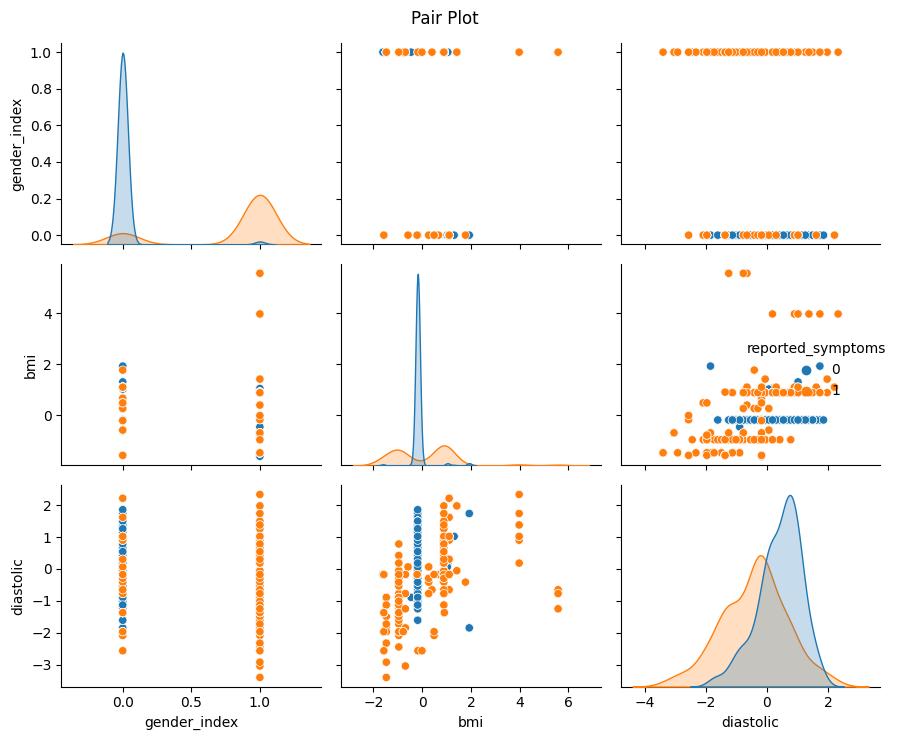

In [36]:
sns.pairplot(normalized_df[['gender_index', 'bmi', 'diastolic', 'reported_symptoms']], hue="reported_symptoms", diag_kind="kde")
plt.suptitle('Pair Plot')
plt.tight_layout()
plt.show()

Gender is a major source of bias for whether or not the participant reported symptoms. Looking only at the scatter plot between `diastolic` and `bmi`, we see that there's an area of concentration for the datapoints associated with participants who did not report symptoms.

## Dimensionality Reduction

Principal Component Analysis 

Both BMI and and the Diastolic Blood Pressure are both Gaussian distributions, which lend itself to Principal Component Analysis. Please note, originally BMI was right-skewed. After log transformation, the data was slightly less skewed and more Gaussian. 

In [37]:
from sklearn.decomposition import PCA
##Select the columns for PCA
X = normalized_df[['bmi', 'diastolic']]

#Initialize PCA to reduce to 1 component (or more if needed)

pca = PCA(n_components=1)

#Fit and transform the data
X_pca = pca.fit_transform(X)

#Create a new DataFrame with the principal component(s)
df_pca = pd.DataFrame(X_pca, columns=['PCA1'])

#Optionally, you can view how much variance is explained by the components
explained_variance = pca.explained_variance_ratio_

#Output the PCA result and explained variance

print([df_pca])
print('Explained variance ratio:', explained_variance)

[         PCA1
0   -0.673982
1    0.844764
2    0.085391
3    0.085391
4    0.338515
..        ...
688  0.223064
689  1.602960
690 -3.441761
691  0.084214
692  0.659694

[693 rows x 1 columns]]
Explained variance ratio: [0.66170966]


# Interpretation

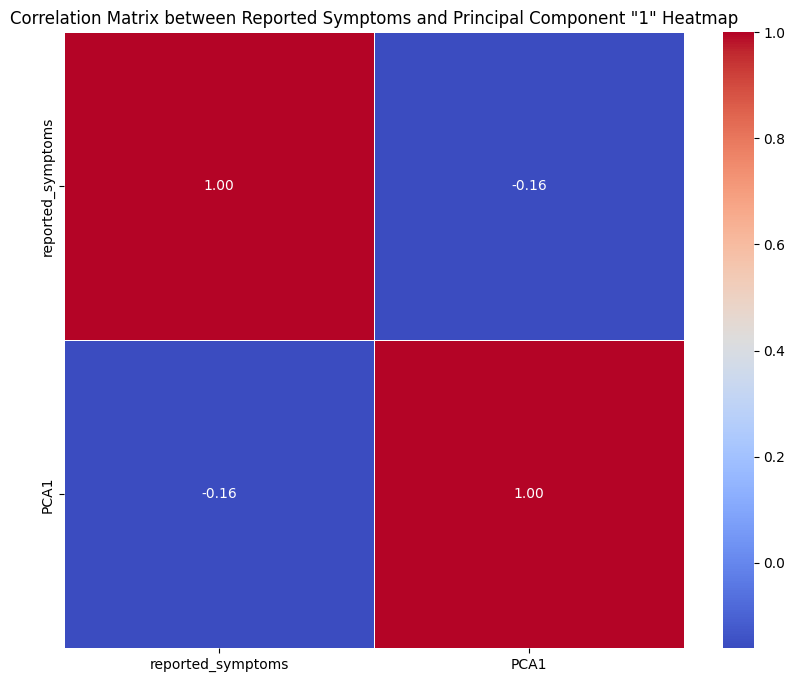

,gender,gender_index,diastolic,reported_symptoms,height,weight,bmi,PCA1
465,m,0,-0.769837,0,174.0,73.4,-0.183318,-0.673982
324,m,0,1.377994,0,174.0,73.4,-0.183318,0.844764
524,m,0,0.304078,0,174.0,73.4,-0.183318,0.085391
478,m,0,0.304078,0,174.0,73.4,-0.183318,0.085391
377,m,0,0.662050,0,174.0,73.4,-0.183318,0.338515
334,m,0,-0.292542,0,174.0,73.4,-0.183318,-0.336483
413,m,0,-0.292542,0,174.0,73.4,-0.183318,-0.336483
434,m,0,-0.531190,0,174.0,73.4,-0.183318,-0.505233
494,m,0,1.139346,0,174.0,73.4,-0.183318,0.676014
363,m,0,0.781374,0,174.0,73.4,-0.183318,0.422890


In [38]:
corrected_df = normalized_df.copy()
corrected_df['PCA1'] = X_pca
correlation_matrix = corrected_df[['reported_symptoms','PCA1']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix between Reported Symptoms and Principal Component "1" Heatmap')
plt.show()
corrected_df.head(10)

The heatmap results show that there is little, if any, correlation between the reported symptoms and the top principal component.  



## Reference

[1] Pravdin, Pavel (2022). *Welltory COVID-19 and Wearables Open Data Research [dataset].* 22 July 2022. Welltory Inc. CC0-1.0 License. https://github.com/Welltory/hrv-covid19